<a href="https://colab.research.google.com/github/PeterDeWeirdt/rs_dev/blob/main/notebooks/03_build_seq_model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Sequence Model

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr 12 12:25:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import multiprocessing
n_cpus = multiprocessing.cpu_count()
print(n_cpus)

4


In [3]:
!pip install -U --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn
!pip install -U lightgbm --install-option=--gpu
!pip install sglearn
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://pypi.anaconda.org/scipy-wheels-nightly/simple
     |████████████████████████████████| 22.4MB 13.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 1.5MB 7.6MB/s 
Skipping wheel build for lightgbm, due to binaries being disabled for it.
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
    Running setup.py install for lightgbm ... done
     |████████████████████████████████| 2.3MB 7.6MB/s 
     |████████████████████████████████| 296kB 7.6MB/s 
     |███████████████████████

In [4]:
import pandas as pd
from datasets_colab import dataset_list
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from lightgbm import LGBMRegressor
from sklearn.base import clone
from sklearn.metrics import r2_score
import sglearn
from scipy import stats
import plotnine as gg
import optuna
from joblib import Parallel, delayed
import numpy as np
from tensorflow import keras
from datetime import datetime


In [5]:
def get_predictive_performance(prediction_list):
    """From a list of dataframes of predictions for each fold for each datasetset for each guide,
    get pearson correlation of each fold/dataset

    :param prediction_list: list of DataFrame
    :return: DataFrame
    """
    test_prediction_df = (pd.concat(prediction_list)
                          .rename({'dataset': 'testing_set'}, axis=1))
    predictive_performance = (test_prediction_df.groupby(['model_name', 'testing_set', 'fold'])
                              .apply(lambda df: stats.pearsonr(df['sgRNA Activity'], df['prediction'])[0])
                              .reset_index(name='pearson_r'))
    predictive_performance['relative_performance'] = (predictive_performance.groupby(['fold', 'testing_set'])
                                                      ['pearson_r']
                                                      .transform(lambda x: x/x.max()))
    median_relative_performance = (predictive_performance.groupby(['model_name'])
                                   .agg(median_performance = ('relative_performance', 'median'))
                                   .reset_index()
                                   .sort_values('median_performance'))
    predictive_performance['model_name'] = pd.Categorical(predictive_performance['model_name'],
                                                            categories=median_relative_performance['model_name'])
    if predictive_performance['testing_set'].isin(predictive_performance['model_name']).all():
        predictive_performance['testing_set'] = pd.Categorical(predictive_performance['testing_set'],
                                                               categories=median_relative_performance['model_name'])
    predictive_performance['fold'] = predictive_performance['fold'].astype('category')
    return predictive_performance


def plot_pearson_heatmap(predictive_performance):
    """Plot heatmap of pearson correlations

    :param predictive_performance: DataFrame from `get_predictive_performance`
    :return: plotnine figure
    """
    g = (gg.ggplot(predictive_performance) +
         gg.aes(x='testing_set', y='model_name', fill='pearson_r') +
         gg.geom_tile(color='black') +
         gg.scale_fill_cmap('RdBu_r', limits=(-1, 1)) +
         gg.theme_classic() +
         gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1)) +
         gg.facet_wrap('fold'))
    return g


def plot_relative_performance(predictive_performance):
    """Plot boxplot of relative performance

    :param predictive_performance: predictive_performance: DataFrame from `get_predictive_performance`
    :return: plotnine figure
    """
    g = (gg.ggplot(predictive_performance) +
         gg.aes(x='model_name', y='relative_performance') +
         gg.geom_point(gg.aes(color='fold'), position=gg.position_dodge(width=0.5)) +
         gg.scale_color_brewer(type='qual', palette='Set2') +
         gg.geom_boxplot(fill=None, outlier_alpha=0) +
         gg.theme_classic() +
         gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1)))
    return g


def train_test_model(train_df, model_name, fold, model, test_df, X_test):
    """Get predictions from train and test model

    :param train_df: DataFrame
    :param model_name: str, name of model
    :param fold: int
    :param model: model with a .fit function
    :param test_df: DataFrame
    :param X_test: DataFrame from sglearn.featurize_guides
    :return: DataFrame, same shape as test_df with columns prediction, model, fold
    """
    X_train = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
    X_train.columns = X_train.columns.str.replace(',', '')
    y_train = train_df['sgRNA Activity']
    model.fit(X_train,  y_train)
    dataset_test_predictions = test_df.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['model_name'] = model_name
    dataset_test_predictions['fold'] = fold
    return dataset_test_predictions


def get_fold_predictions(fold, fold_df,
                         base_model=LGBMRegressor(random_state=7, n_jobs=8),
                         top_training_set=None, combine_datasets=None, model_name=None):
    """Get predictions for a given fold, allowing for each dataset to be trained separately,
    or multiple datasets trained together

    :param fold: int
    :param fold_df: DataFrame
    :param base_model: model with a .fit function
    :param top_training_set: str
    :param combine_datasets: list of
    :param model_name: str optional, only relevant if top_datasets is specified
    :return: list of DataFrame, list of test predictions
    """
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = sglearn.featurize_guides(fold_test_data['sgRNA Context Sequence'])
    X_test.columns = X_test.columns.str.replace(',', '')
    test_prediction_list = []
    if combine_datasets is None:
        for dataset, dataset_df in fold_train_data.groupby('dataset'):
            dataset_df = dataset_df.reset_index(drop=True)
            # Join together top training set and current dataset
            if top_training_set is not None:
                if dataset != top_training_set:
                    top_dataset_df = fold_train_data[fold_train_data.dataset == top_training_set]
                    dataset_df = pd.concat([dataset_df, top_dataset_df]).reset_index(drop=True)
                    dataset_df['sgRNA Activity'] = (dataset_df.groupby('dataset')
                                                    ['sgRNA Activity']
                                                    .rank(pct=True))
                    dataset += ' + ' + top_training_set
            model = clone(base_model)
            dataset_test_predictions = train_test_model(dataset_df, dataset, fold, model, fold_test_data, X_test)
            test_prediction_list.append(dataset_test_predictions)
    else:
        train_df = fold_train_data[fold_train_data.dataset.isin(combine_datasets)].reset_index(drop=True)
        train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                      ['sgRNA Activity']
                                      .rank(pct=True))
        model = clone(base_model)
        if model_name is None:
            model_name = ' + '.join(combine_datasets)
        dataset_test_predictions = train_test_model(train_df, model_name, fold,
                                                    model, fold_test_data, X_test)
        # For consistency we return a list of len 1
        test_prediction_list.append(dataset_test_predictions)
    return test_prediction_list

In [6]:
train_data_names = pd.read_csv('train_data_names.csv').name.to_list()

In [7]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.get_sgrnas()

## Cross-Validation Iterator

We'll use [StratifiedGroupKFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)

>This cross-validation object is a variation of StratifiedKFold attempts to return stratified folds with
> non-overlapping groups. The folds are made by preserving the percentage of samples for each class.

>The same group will not appear in two different folds (the number of distinct groups has to be at least equal to
> the number of folds).

>The difference between GroupKFold and StratifiedGroupKFold is that the former attempts to create balanced folds such
> that the number of distinct groups is approximately the same in each fold, whereas StratifiedGroupKFold attempts to
> create folds which preserve the percentage of samples for each class as much as possible given the
> constraint of non-overlapping groups between splits.

In our case, we define each dataset as a "class", such that the datasets are approximately equally distributed across
folds, constrained by the notion that each "group" or gene cannot appear in both the train and test set in a given fold.

First, we assign sgRNAs to genes, capitalizing gene-names from the mouse libraries, so they overlap with the human annotations.
We can see that every context sequence uniquely targets a gene in this dataset

In [8]:
sg_df_list = []
for ds in train_data_list:
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    sg_df_list.append(sg_df)
sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
multi_target = sg_df_groups['target'].str.contains(',').sum()
print('Context sequences with multiple targets: ' + str(multi_target))

Context sequences with multiple targets: 0


We assign context sequences without a group to their own group. Every dataset appears as both a training and testing
dataset in every fold, except Doench2014_human Doench2014_mouse, which have fewer than 5 genes

In [9]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row:
                                            row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'],
                                            axis=1)
# Note that 'target' is not in the sg_df_list, and is coming from the sg_df_groups df
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])                      
                      .reset_index(drop=True))
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
tidy_cv_list = []
for i, (train_index, test_index) in enumerate(sgkf.split(sg_df_class_groups, sg_df_class_groups.dataset,
                                                         sg_df_class_groups.target)):
    train_df = sg_df_class_groups.iloc[train_index,:].copy()
    train_df['cv'] = i
    train_df['train'] = True
    tidy_cv_list.append(train_df)
    test_df = sg_df_class_groups.iloc[test_index,:].copy()
    test_df['cv'] = i
    test_df['train'] = False
    tidy_cv_list.append(test_df)
tidy_cv_df = pd.concat(tidy_cv_list)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
cv_train_data_counts

,cv,train,dataset,n
0,3,True,Kim2019_train,10604
1,1,True,Kim2019_train,10574
2,4,True,Kim2019_train,10354
3,0,True,Kim2019_train,10267
4,2,True,Kim2019_train,9529
5,2,False,Kim2019_train,3303
6,0,False,Kim2019_train,2565
7,4,False,Kim2019_train,2478
8,1,True,Doench2016,2319
9,1,False,Kim2019_train,2258


In [10]:
(cv_train_data_counts[['cv', 'dataset']]
 .value_counts()
 .reset_index(name='n'))

,cv,dataset,n
0,4,Wang2014,2
1,2,Doench2014_mouse,2
2,0,Doench2014_mouse,2
3,0,Doench2016,2
4,0,Kim2019_train,2
5,0,Wang2014,2
6,1,Doench2014_human,2
7,1,Doench2014_mouse,2
8,1,Doench2016,2
9,1,Kim2019_train,2


The size of the training and testing sets are approximately equal across folds,
with training sets varying between 13,107 (fold 2) - 15,847 (fold 3) sgRNAs and testing sets varying
between 2,707 (fold 3) - 5,447 (fold 2) sgRNAs


In [11]:
(tidy_cv_df[['cv','train']].value_counts()
 .reset_index(name='n')
 .sort_values(['cv', 'train']))

,cv,train,n
6,0,False,3843
3,0,True,14711
8,1,False,3033
1,1,True,15521
5,2,False,5447
4,2,True,13107
9,3,False,2707
0,3,True,15847
7,4,False,3524
2,4,True,15030


Indeed each gene target (gene) only appears in one fold

In [12]:
(tidy_cv_df[['cv','train', 'target']].value_counts()
 .reset_index(name='n')
 .query('n > 10')
 [['cv', 'target']].value_counts()
 .reset_index(name='train_test_sum')
 .groupby('cv')
 .agg({'train_test_sum': ['max']}))

,train_test_sum
,max
cv,
0,1
1,1
2,1
3,1
4,1


## Train each dataset separately
Now we'll move onto training and first we'll train each dataset separately

In [13]:
single_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    single_test_prediction_list.extend(get_fold_predictions(fold, df))
    print('\n')

single_predictive_performance = get_predictive_performance(single_test_prediction_list)

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4




Importantly, all training datasets are successful at predicting held-out test data

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



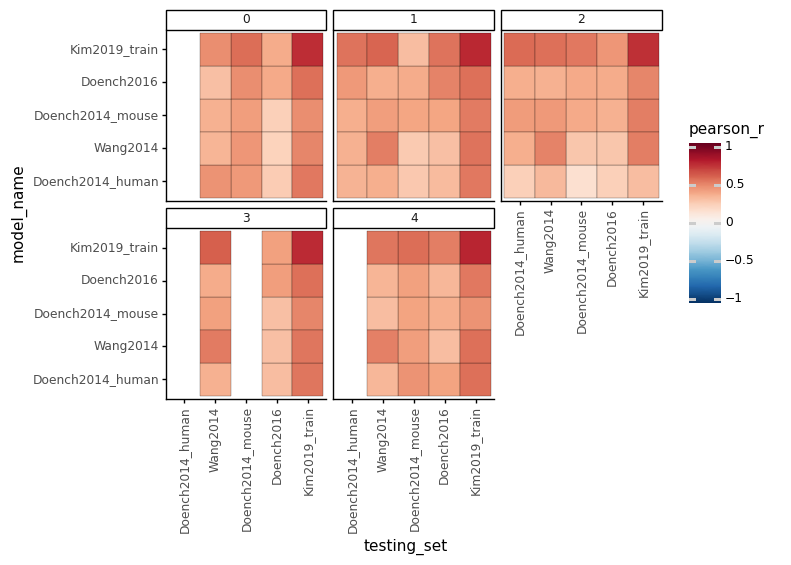

<ggplot: (8768026454073)>

In [14]:
plot_pearson_heatmap(single_predictive_performance)

We can see that the Kim training data outperforms all the rest, but it's also quite a bit bigger than the next biggest dataset

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



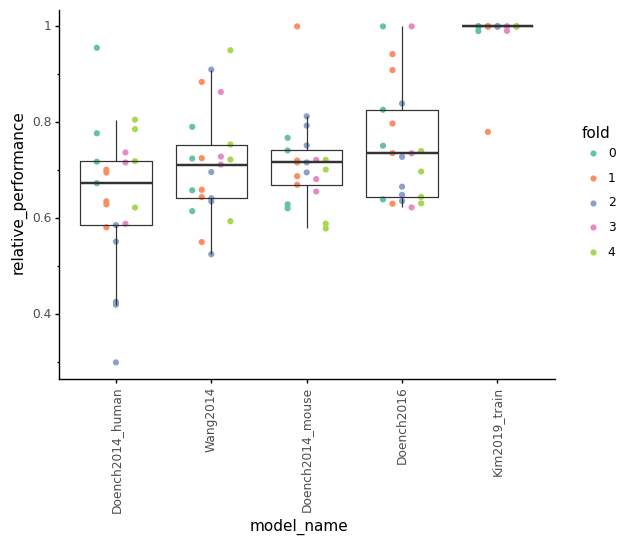

<ggplot: (8768004191521)>

In [15]:
plot_relative_performance(single_predictive_performance)


## Combining training datasets

If we merge the training datasets, can we improve our performance?
We'll merge by normalizing activity to a percent rank.

In [16]:
top_training_set = (single_predictive_performance.groupby('model_name')
                    .agg({'relative_performance': 'median'})
                    .reset_index()
                    .sort_values('relative_performance', ascending=False)
                    ['model_name']
                    .values[0])
print('Top training set: ' + top_training_set)

Top training set: Kim2019_train


In [17]:
combined_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: '+ str(fold))
    combined_test_prediction_list.extend(get_fold_predictions(fold, df, top_training_set=top_training_set))
    print('\n')

combined_predictive_performance = get_predictive_performance(combined_test_prediction_list)

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4




/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



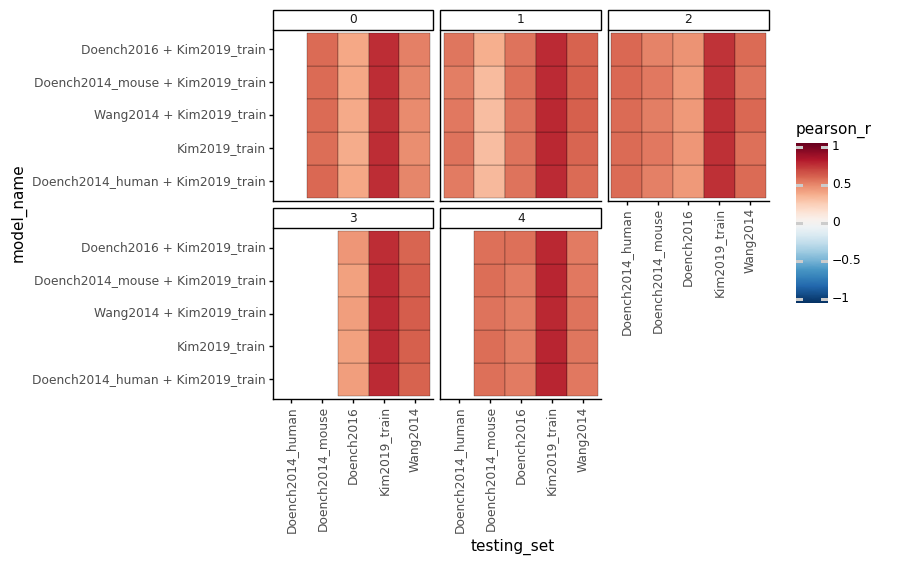

<ggplot: (8768001385061)>

In [18]:
plot_pearson_heatmap(combined_predictive_performance)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



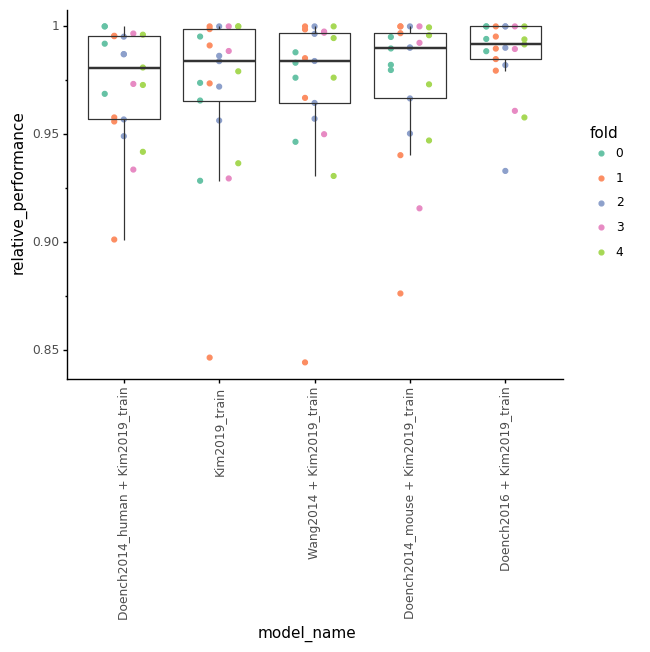

<ggplot: (8768025043845)>

In [19]:
plot_relative_performance(combined_predictive_performance)

We'll keep all training sets that don't significantly reduce predictive performance, which is all training sets

In [20]:
ttest_list = []
reference_scores = (combined_predictive_performance
                    .loc[combined_predictive_performance['model_name'] == top_training_set, 'pearson_r'])
for model_name, training_set_df in combined_predictive_performance.groupby('model_name'):
    compare_scores = training_set_df['pearson_r']
    t, p = stats.ttest_rel(reference_scores, compare_scores)
    ttest_list.append({'model_name': model_name, 't': t, 'p': p})
ttest_df = pd.DataFrame(ttest_list)
ttest_df.sort_values('t')

,model_name,t,p
4,Doench2016 + Kim2019_train,-1.369329,0.186078
3,Doench2014_mouse + Kim2019_train,-0.583353,0.566177
2,Wang2014 + Kim2019_train,-0.294929,0.771087
0,Doench2014_human + Kim2019_train,-0.010322,0.991867
1,Kim2019_train,NaN,NaN


We'll try combining all datasets which don't significantly decrease performance

In [21]:
combine_datasets =  (ttest_df
    .loc[(ttest_df.t.fillna(0) < 0) | (ttest_df.p.fillna(1) > 0.05), 'model_name']
    .str.split(' \+ ', expand=True)[0])
print('Combine datasets: ' + ', '.join(combine_datasets))

Combine datasets: Doench2014_human, Kim2019_train, Wang2014, Doench2014_mouse, Doench2016


In [22]:
top_combined_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    top_combined_test_prediction_list.extend(get_fold_predictions(fold, df, combine_datasets=combine_datasets,
                                                                  model_name='All train data'))
    print('\n')

top_dual_model = ttest_df.sort_values('t')['model_name'].values[0]
print('Reference model: ' + str(top_dual_model))
top_dual_prediction_list = [df for df in combined_test_prediction_list if (df.model_name == top_dual_model).all()]
top_combined_predictive_performance = get_predictive_performance(top_combined_test_prediction_list +
                                                                 top_dual_prediction_list)

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4


Reference model: Doench2016 + Kim2019_train


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



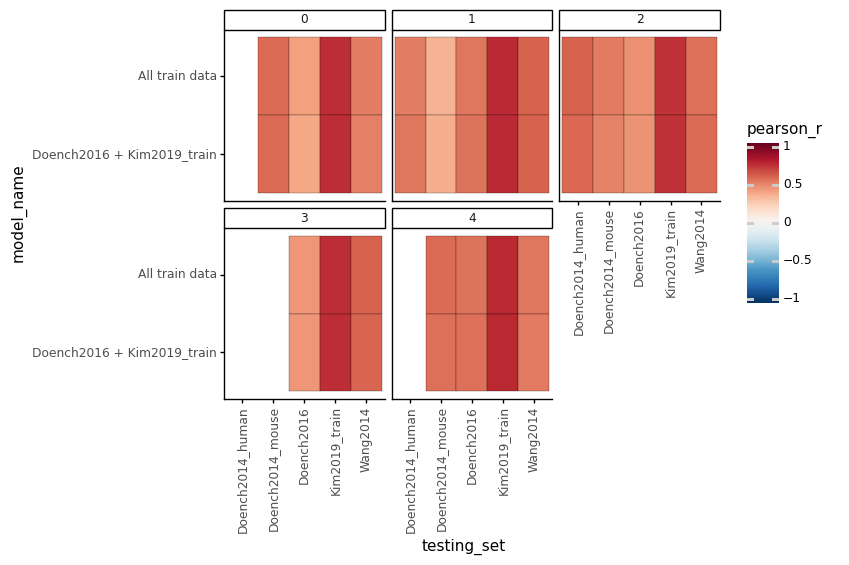

<ggplot: (8767982756573)>

In [23]:
plot_pearson_heatmap(top_combined_predictive_performance)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



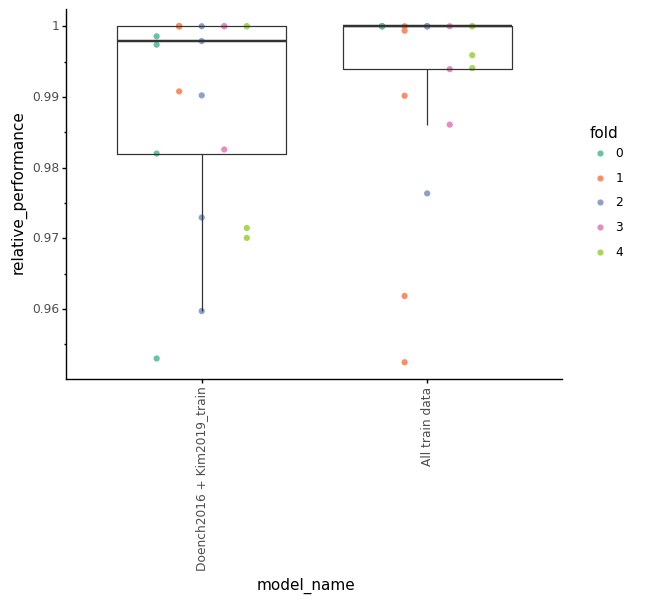

<ggplot: (8768015502233)>

In [24]:
plot_relative_performance(top_combined_predictive_performance)

## Sequence Model Hyperparameter Tuning

Using the combined datasets, we'll try different model architectures and use hyperparameter tuning.
For the hyperparmeter tuning, we'll use the [optuna library](https://optuna.readthedocs.io/en/stable/index.html),
which by default uses the Tree-structured Parzen Estimator to search the hyperparameter space.

In [25]:
n_trials = 50

### LightGBM

In [26]:
def lgbm_training_iteration(fold_df, train_index, test_index, base_model):
    """Train lgbm model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param test_index: list-like
    :param base_model: LGBMRegressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                  ['sgRNA Activity']
                                  .rank(pct=True))
    X_train_val = sglearn.featurize_guides(train_df['sgRNA Context Sequence']) # train and validation data
    X_train_val.columns = X_train_val.columns.str.replace(',', '') # problem with lgbm regressor c code
    y_train_val = train_df['sgRNA Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = clone(base_model)
    model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=False)
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    X_test = sglearn.featurize_guides(test_df['sgRNA Context Sequence'])
    X_test.columns = X_test.columns.str.replace(',', '')
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['sgRNA Activity'] = (test_predictions.groupby('dataset')
                                          ['sgRNA Activity']
                                          .rank(pct=True))
    r2 = r2_score(test_predictions['sgRNA Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(fold_df):
    """Get objective function for training a lgbm model

    :param fold_df: DataFrame
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for lgbm

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        num_leaves = trial.suggest_int('num_leaves', 8, 256)
        min_child_samples = trial.suggest_int('min_child_samples', 8, 256)
        model = LGBMRegressor(random_state=7, learning_rate=0.01, 
                              n_estimators=5000,
                              num_leaves=num_leaves,
                              min_child_samples=min_child_samples)
        performance = Parallel(n_jobs=5)(delayed(lgbm_training_iteration)
                                         (fold_df, train_index, test_index, model) for
                                         train_index, test_index in
                                         sgkf.split(fold_df, fold_df.dataset, fold_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective

In [27]:
lgbm_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    study = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
    objective = get_lgbm_objective(fold_train_data)
    start_time = datetime.now()
    study.optimize(objective, n_trials=n_trials)
    end_time = datetime.now()
    difference = end_time - start_time
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Training Time: " + str(difference))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    # Using optimal parameters, retrain model with full dataset
    train_df = fold_train_data.copy()
    train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                  ['sgRNA Activity']
                                  .rank(pct=True))
    X_train_val = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
    X_train_val.columns = X_train_val.columns.str.replace(',', '')
    y_train_val = train_df['sgRNA Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = LGBMRegressor(random_state=7, learning_rate=0.01, n_estimators=5000, 
                          n_jobs=8,
                          **trial.params)
    model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=1000)
    # Test optimal model on test data
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = sglearn.featurize_guides(fold_test_data['sgRNA Context Sequence'])
    X_test.columns = X_test.columns.str.replace(',', '')
    test_predictions = fold_test_data.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['model_name'] = 'All train data + LGBM + TPE' + str(n_trials)
    test_predictions['fold'] = fold
    lgbm_prediction_list.append(test_predictions)

[I 2021-04-12 12:33:03,224] A new study created in memory with name: no-name-cde90222-abb0-4e9d-852b-572bd18803fc


Fold: 0


[I 2021-04-12 12:33:43,931] Trial 0 finished with value: 0.46815613229001957 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.46815613229001957.
[I 2021-04-12 12:34:20,420] Trial 1 finished with value: 0.4635367586996472 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.46815613229001957.
[I 2021-04-12 12:34:59,558] Trial 2 finished with value: 0.4644463229035348 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.46815613229001957.
[I 2021-04-12 12:35:36,488] Trial 3 finished with value: 0.44943068091006744 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 0 with value: 0.46815613229001957.
[I 2021-04-12 12:36:14,165] Trial 4 finished with value: 0.46643317377267496 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 0 with value: 0.46815613229001957.
[I 2021-04-12 12:36:53,528] Trial 5 finished with value: 0.4

Number of finished trials: 50
Training Time: 0:31:36.918942
Best trial:
  Value: 0.4696858629853152
  Params: 
    num_leaves: 25
    min_child_samples: 135
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.0449874
[2000]	valid_0's l2: 0.0430933
Early stopping, best iteration is:
[2592]	valid_0's l2: 0.0425458


[I 2021-04-12 13:05:12,094] A new study created in memory with name: no-name-e155bee3-0caf-456b-9cbd-81bf0bd38273


Fold: 1


[I 2021-04-12 13:05:50,865] Trial 0 finished with value: 0.44777738129358713 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.44777738129358713.
[I 2021-04-12 13:06:29,683] Trial 1 finished with value: 0.4473894527220866 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.44777738129358713.
[I 2021-04-12 13:07:09,274] Trial 2 finished with value: 0.44742906809145816 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.44777738129358713.
[I 2021-04-12 13:07:46,261] Trial 3 finished with value: 0.430672254214986 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 0 with value: 0.44777738129358713.
[I 2021-04-12 13:08:23,346] Trial 4 finished with value: 0.4464246424552396 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 0 with value: 0.44777738129358713.
[I 2021-04-12 13:09:02,750] Trial 5 finished with value: 0.445

Number of finished trials: 50
Training Time: 0:31:39.824339
Best trial:
  Value: 0.4515920749804718
  Params: 
    num_leaves: 31
    min_child_samples: 138
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.045938
Early stopping, best iteration is:
[1719]	valid_0's l2: 0.0446349


[I 2021-04-12 13:37:21,926] A new study created in memory with name: no-name-6b818a55-a06e-4fe0-8a72-e07b614da5d4


Fold: 2


[I 2021-04-12 13:37:54,575] Trial 0 finished with value: 0.4568944619093819 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.4568944619093819.
[I 2021-04-12 13:38:26,654] Trial 1 finished with value: 0.4563903595726327 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.4568944619093819.
[I 2021-04-12 13:38:59,131] Trial 2 finished with value: 0.4574017395409474 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 2 with value: 0.4574017395409474.
[I 2021-04-12 13:39:31,389] Trial 3 finished with value: 0.4394509191659446 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 2 with value: 0.4574017395409474.
[I 2021-04-12 13:40:01,425] Trial 4 finished with value: 0.4530232493424144 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 2 with value: 0.4574017395409474.
[I 2021-04-12 13:40:35,224] Trial 5 finished with value: 0.455665969

Number of finished trials: 50
Training Time: 0:26:39.230031
Best trial:
  Value: 0.4574017395409474
  Params: 
    num_leaves: 251
    min_child_samples: 142
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.0424532
Early stopping, best iteration is:
[1274]	valid_0's l2: 0.0420565


[I 2021-04-12 14:04:35,321] A new study created in memory with name: no-name-fb5a3c11-e4b7-49e8-90b1-14f0a459faf0


Fold: 3


[I 2021-04-12 14:05:19,805] Trial 0 finished with value: 0.45551476262349266 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.45551476262349266.
[I 2021-04-12 14:06:01,067] Trial 1 finished with value: 0.4525511699451819 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.45551476262349266.
[I 2021-04-12 14:06:40,265] Trial 2 finished with value: 0.4524351277819024 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.45551476262349266.
[I 2021-04-12 14:07:18,492] Trial 3 finished with value: 0.4371214746337996 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 0 with value: 0.45551476262349266.
[I 2021-04-12 14:07:59,434] Trial 4 finished with value: 0.45337910332987097 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 0 with value: 0.45551476262349266.
[I 2021-04-12 14:08:42,959] Trial 5 finished with value: 0.45

Number of finished trials: 50
Training Time: 0:33:26.871701
Best trial:
  Value: 0.45719558525602927
  Params: 
    num_leaves: 34
    min_child_samples: 113
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.0444468
[2000]	valid_0's l2: 0.043022
Early stopping, best iteration is:
[2125]	valid_0's l2: 0.0429412


[I 2021-04-12 14:38:38,804] A new study created in memory with name: no-name-20021f6c-bb4b-4c2a-9bad-4f00a5558aaa


Fold: 4


[I 2021-04-12 14:39:20,384] Trial 0 finished with value: 0.45567554294488194 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.45567554294488194.
[I 2021-04-12 14:39:59,417] Trial 1 finished with value: 0.4556573102490062 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.45567554294488194.
[I 2021-04-12 14:40:37,945] Trial 2 finished with value: 0.4532003079545984 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.45567554294488194.
[I 2021-04-12 14:41:14,789] Trial 3 finished with value: 0.43843697019270633 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 0 with value: 0.45567554294488194.
[I 2021-04-12 14:41:52,574] Trial 4 finished with value: 0.45590467037516047 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 4 with value: 0.45590467037516047.
[I 2021-04-12 14:42:32,677] Trial 5 finished with value: 0.4

Number of finished trials: 50
Training Time: 0:31:43.643565
Best trial:
  Value: 0.4572980863157933
  Params: 
    num_leaves: 35
    min_child_samples: 148
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.0454314
Early stopping, best iteration is:
[1609]	valid_0's l2: 0.0443248


In [28]:
lgbm_predictive_performance = get_predictive_performance(top_combined_test_prediction_list +
                                                         lgbm_prediction_list)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



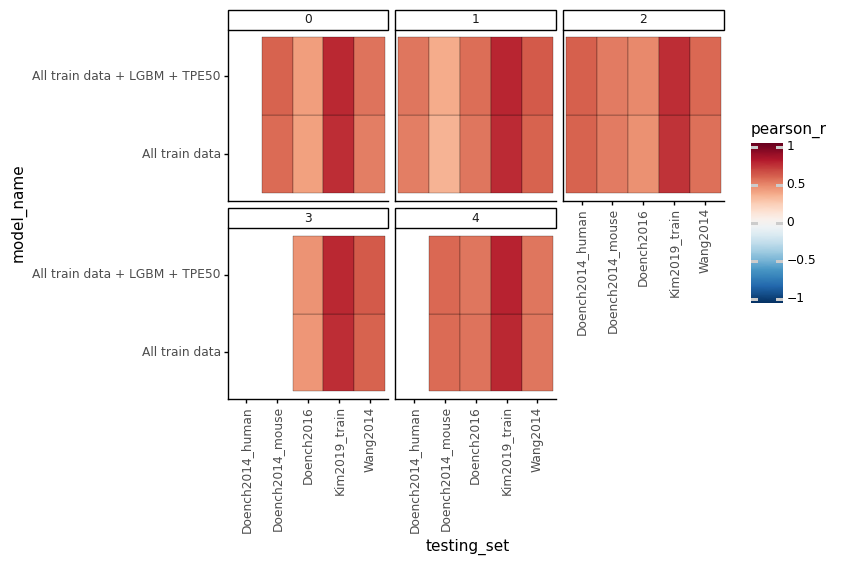

<ggplot: (8767983275749)>

In [29]:
plot_pearson_heatmap(lgbm_predictive_performance)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



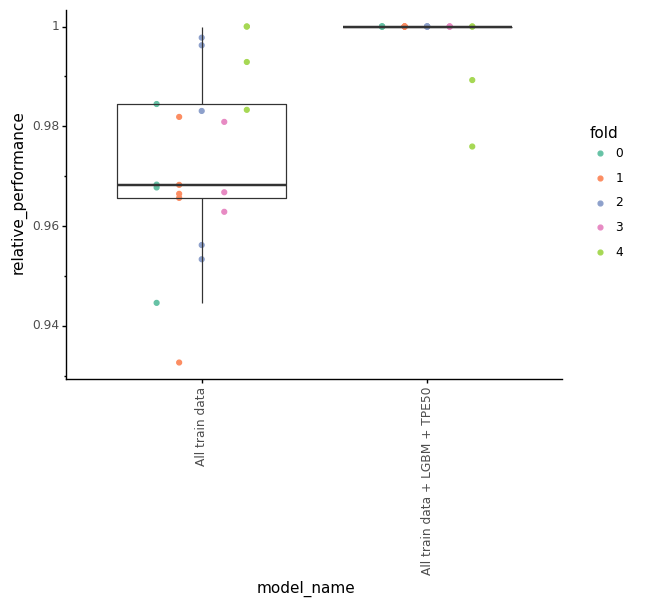

<ggplot: (8767981222473)>

In [30]:
plot_relative_performance(lgbm_predictive_performance)


### Keras Convolutional Neural Network

In [31]:
def get_cnn(n_conv_layers, filters_per_conv, filter_len,
            nodes_per_dense, dense_dropout_rate, n_dense_layers=1,
            input_shape=(30, 4), activation='relu', initializer='he_uniform',
            pool_size=2, loss='mse', optimizer='Adam'):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for _ in range(n_conv_layers):
        model.add(keras.layers.Conv1D(filters=filters_per_conv, kernel_size=filter_len,
                                      activation=activation, kernel_initializer=initializer))
        model.add(keras.layers.AveragePooling1D(pool_size=pool_size))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(dense_dropout_rate))
    for _ in range(n_dense_layers):
        model.add(keras.layers.Dense(nodes_per_dense, activation=activation, kernel_initializer=initializer))
        model.add(keras.layers.Dropout(dense_dropout_rate))
    model.add(keras.layers.Dense(1, activation='linear'))
    model.compile(loss=loss, optimizer=optimizer)
    return model

nt_codes = {'A':[1,0,0,0],
            'C':[0,1,0,0],
            'G':[0,0,1,0],
            'T':[0,0,0,1]}

def encode_seqs(seqs):
    # 3d array with samples x position x nt
    encoded_seqs = np.array([[nt_codes.get(x) for x in seq] for seq in seqs])
    return encoded_seqs


def cnn_training_iteration(fold_df, train_index, test_index, base_model):
    """Train cnn model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param test_index: list-like
    :param base_model: KerasRegressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                  ['sgRNA Activity']
                                  .rank(pct=True))
    train_val_seqs = train_df['sgRNA Context Sequence'] # train and validation data
    y_train_val = train_df['sgRNA Activity']
    train_seqs, val_seqs, y_train, y_val = train_test_split(train_val_seqs, y_train_val,
                                                            test_size=0.1, random_state=7)
    X_train = encode_seqs(train_seqs)
    X_val = encode_seqs(val_seqs)
    model = clone(base_model)
    model.fit(X_train, y_train, verbose=0, validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=20)])
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    X_test = encode_seqs(test_df['sgRNA Context Sequence'])
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['sgRNA Activity'] = (test_predictions.groupby('dataset')
                                          ['sgRNA Activity']
                                          .rank(pct=True))
    r2 = r2_score(test_predictions['sgRNA Activity'], test_predictions['prediction'])
    return r2


def get_cnn_objective(fold_df):
    """Get objective function for training a cnn model

    :param fold_df: DataFrame
    :return: objective function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for cnn

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        n_conv_layers = trial.suggest_int('n_conv_layers', 1, 2)
        filters_per_conv = trial.suggest_int('filters_per_conv', 32, 256)
        filter_len = trial.suggest_int('filter_len', 2, 8)
        nodes_per_dense = trial.suggest_int('nodes_per_dense', 8, 256)
        dense_dropout_rate = trial.suggest_float('dense_dropout_rate', 0.1, 0.5)
        model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=get_cnn, epochs=5000,
                                                           n_conv_layers=n_conv_layers,
                                                           filters_per_conv=filters_per_conv,
                                                           filter_len=filter_len,
                                                           nodes_per_dense=nodes_per_dense,
                                                           dense_dropout_rate=dense_dropout_rate)
        performance = Parallel(n_jobs=5)(delayed(cnn_training_iteration)
                                         (fold_df, train_index, test_index, model) for
                                         train_index, test_index in
                                         sgkf.split(fold_df, fold_df.dataset, fold_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective

In [32]:
cnn_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    study = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
    objective = get_cnn_objective(fold_train_data)
    start_time = datetime.now()
    study.optimize(objective, n_trials=n_trials)
    end_time = datetime.now()
    difference = end_time - start_time
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Training Time: " + str(difference))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    # Using optimal parameters, retrain model with full dataset
    train_df = fold_train_data.copy()
    train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                  ['sgRNA Activity']
                                  .rank(pct=True))
    train_val_seqs = train_df['sgRNA Context Sequence'] # train and validation data
    y_train_val = train_df['sgRNA Activity']
    train_seqs, val_seqs, y_train, y_val = train_test_split(train_val_seqs, y_train_val,
                                                            test_size=0.1, random_state=7)
    X_train = encode_seqs(train_seqs)
    X_val = encode_seqs(val_seqs)
    model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=get_cnn, epochs=5000,
                                                       **trial.params)
    model.fit(X_train, y_train, verbose=0, validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=20)])
    # Test optimal model on test data
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = encode_seqs(fold_test_data['sgRNA Context Sequence'])
    test_predictions = fold_test_data.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['model_name'] = 'All train data + CNN + TPE' + str(n_trials)
    test_predictions['fold'] = fold
    cnn_prediction_list.append(test_predictions)

[I 2021-04-12 15:10:54,862] A new study created in memory with name: no-name-0845ed1f-c413-4817-b0d7-62d7808f0fc4


Fold: 0


[I 2021-04-12 15:13:27,367] Trial 0 finished with value: 0.4534364717108884 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.4534364717108884.
[I 2021-04-12 15:15:48,299] Trial 1 finished with value: 0.41217903115632726 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 144, 'filter_len': 2, 'nodes_per_dense': 74, 'dense_dropout_rate': 0.299953000330224}. Best is trial 0 with value: 0.4534364717108884.
[I 2021-04-12 15:17:21,948] Trial 2 finished with value: 0.4172665081297554 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 212, 'filter_len': 4, 'nodes_per_dense': 24, 'dense_dropout_rate': 0.21525823972319744}. Best is trial 0 with value: 0.4534364717108884.
[I 2021-04-12 15:18:39,579] Trial 3 finished with value: 0.36872634997078657 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 80, 'filter_len': 5, 'nodes_per_dense': 239, 'dense_dropo

Number of finished trials: 50
Training Time: 1:45:31.187193
Best trial:
  Value: 0.46067707623948645
  Params: 
    n_conv_layers: 1
    filters_per_conv: 246
    filter_len: 5
    nodes_per_dense: 206
    dense_dropout_rate: 0.48102928264479183


[I 2021-04-12 16:57:22,751] A new study created in memory with name: no-name-5c8cb685-182b-4cd4-a384-06ec4aa98a14


Fold: 1


[I 2021-04-12 16:59:34,937] Trial 0 finished with value: 0.44053856783046796 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.44053856783046796.
[I 2021-04-12 17:01:36,422] Trial 1 finished with value: 0.40511345459816245 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 144, 'filter_len': 2, 'nodes_per_dense': 74, 'dense_dropout_rate': 0.299953000330224}. Best is trial 0 with value: 0.44053856783046796.
[I 2021-04-12 17:03:21,191] Trial 2 finished with value: 0.4019943232373134 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 212, 'filter_len': 4, 'nodes_per_dense': 24, 'dense_dropout_rate': 0.21525823972319744}. Best is trial 0 with value: 0.44053856783046796.
[I 2021-04-12 17:04:34,359] Trial 3 finished with value: 0.3599834344377218 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 80, 'filter_len': 5, 'nodes_per_dense': 239, 'dense_dr

Number of finished trials: 50
Training Time: 1:37:24.710380
Best trial:
  Value: 0.44910579613782475
  Params: 
    n_conv_layers: 1
    filters_per_conv: 231
    filter_len: 7
    nodes_per_dense: 224
    dense_dropout_rate: 0.44724265023161397


[I 2021-04-12 18:35:24,178] A new study created in memory with name: no-name-0ed15546-4ae7-4353-bb56-0ad6699c07b5


Fold: 2


[I 2021-04-12 18:37:16,600] Trial 0 finished with value: 0.44634295254863526 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.44634295254863526.
[I 2021-04-12 18:38:58,835] Trial 1 finished with value: 0.413708685705273 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 144, 'filter_len': 2, 'nodes_per_dense': 74, 'dense_dropout_rate': 0.299953000330224}. Best is trial 0 with value: 0.44634295254863526.
[I 2021-04-12 18:40:28,205] Trial 2 finished with value: 0.4035572578479618 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 212, 'filter_len': 4, 'nodes_per_dense': 24, 'dense_dropout_rate': 0.21525823972319744}. Best is trial 0 with value: 0.44634295254863526.
[I 2021-04-12 18:41:33,885] Trial 3 finished with value: 0.36600164713336925 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 80, 'filter_len': 5, 'nodes_per_dense': 239, 'dense_dro

Number of finished trials: 50
Training Time: 1:37:37.262268
Best trial:
  Value: 0.45976789758474246
  Params: 
    n_conv_layers: 1
    filters_per_conv: 218
    filter_len: 5
    nodes_per_dense: 82
    dense_dropout_rate: 0.47272401710700196


[I 2021-04-12 20:14:06,146] A new study created in memory with name: no-name-ec1df711-4c57-48b0-bfc3-ba9154a158f5


Fold: 3


[I 2021-04-12 20:16:20,581] Trial 0 finished with value: 0.4467837645151974 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.4467837645151974.
[I 2021-04-12 20:18:36,949] Trial 1 finished with value: 0.40788240438383044 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 144, 'filter_len': 2, 'nodes_per_dense': 74, 'dense_dropout_rate': 0.299953000330224}. Best is trial 0 with value: 0.4467837645151974.
[I 2021-04-12 20:20:28,174] Trial 2 finished with value: 0.40912104551374745 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 212, 'filter_len': 4, 'nodes_per_dense': 24, 'dense_dropout_rate': 0.21525823972319744}. Best is trial 0 with value: 0.4467837645151974.
[I 2021-04-12 20:21:43,502] Trial 3 finished with value: 0.3553352565805693 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 80, 'filter_len': 5, 'nodes_per_dense': 239, 'dense_dropo

Number of finished trials: 50
Training Time: 1:39:44.669916
Best trial:
  Value: 0.4470506850675885
  Params: 
    n_conv_layers: 1
    filters_per_conv: 248
    filter_len: 5
    nodes_per_dense: 214
    dense_dropout_rate: 0.4466893735855903


[I 2021-04-12 21:54:38,188] A new study created in memory with name: no-name-2b904ffc-545a-4dc5-99ed-421441752d80


Fold: 4


[I 2021-04-12 21:56:50,538] Trial 0 finished with value: 0.44728227302041823 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.44728227302041823.
[I 2021-04-12 21:58:58,491] Trial 1 finished with value: 0.40546423496821465 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 144, 'filter_len': 2, 'nodes_per_dense': 74, 'dense_dropout_rate': 0.299953000330224}. Best is trial 0 with value: 0.44728227302041823.
[I 2021-04-12 22:00:43,365] Trial 2 finished with value: 0.3961000981984779 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 212, 'filter_len': 4, 'nodes_per_dense': 24, 'dense_dropout_rate': 0.21525823972319744}. Best is trial 0 with value: 0.44728227302041823.
[I 2021-04-12 22:02:01,529] Trial 3 finished with value: 0.3466686740758086 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 80, 'filter_len': 5, 'nodes_per_dense': 239, 'dense_dr

Number of finished trials: 50
Training Time: 1:49:44.157643
Best trial:
  Value: 0.45014003117199064
  Params: 
    n_conv_layers: 1
    filters_per_conv: 170
    filter_len: 5
    nodes_per_dense: 123
    dense_dropout_rate: 0.4764617824654699


In [33]:
cnn_predictive_performance = get_predictive_performance(lgbm_prediction_list +
                                                        cnn_prediction_list)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



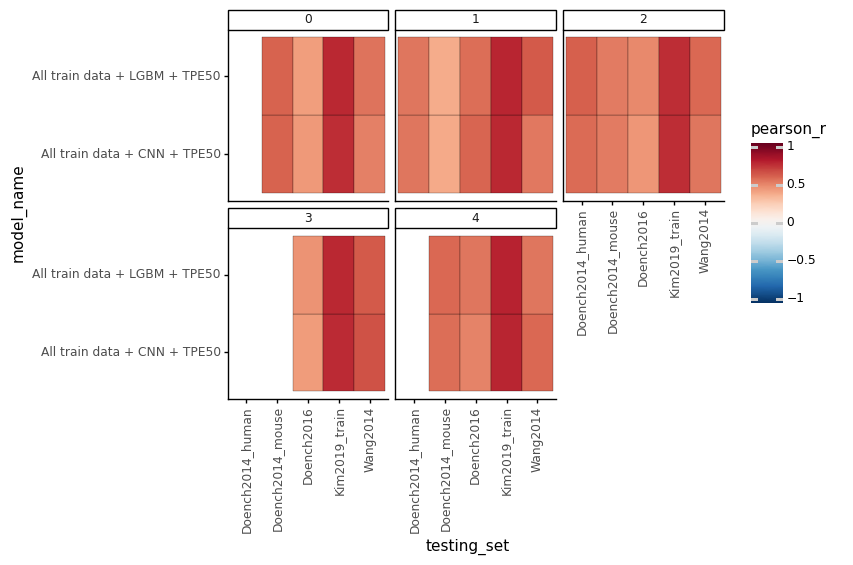

<ggplot: (8767981222585)>

In [34]:
plot_pearson_heatmap(cnn_predictive_performance)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



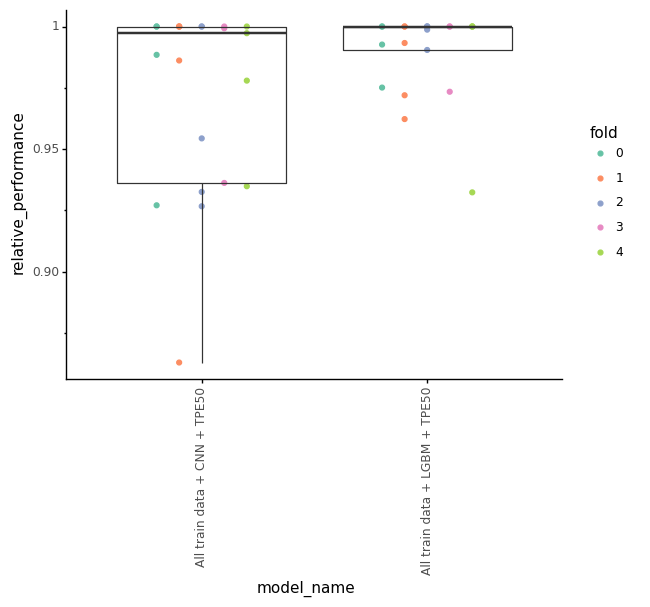

<ggplot: (8768025043057)>

In [35]:
plot_relative_performance(cnn_predictive_performance)